<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-04/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 04
## Author: Colin Scherer

### Part 1: RNNs

In [2]:
import numpy as np
import pandas as pd
# import contractions
import re
import torch
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/YoutubeCommentsDataSet.csv")

# Used for balancing the dataset
def load_dataset(dat, tar):
  vals, cts = np.unique(tar, return_counts=True)
  min_val = vals[np.argmin(cts)]
  min_ct = min(cts)
  new_dat = dat[tar == min_val]
  new_tar = tar[tar == min_val]
  for i, v in enumerate(vals):
    if v != min_val:
      indices = list(np.where(tar == v))[0]
      new_ind = np.random.choice(indices, min_ct)
      new_dat = np.append(new_dat, dat[new_ind], axis=0)
      new_tar = np.append(new_tar, tar[new_ind])
  return new_dat, new_tar

  # Function to clean text for sentiment analysis
def clean_text(text):
    text = str(text).lower() # Convert to lowercase
    # text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\.\S+", "", text) # Remove URLs starting with http/https or www
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@usernames) to avoid irrelevant tokens
    text = re.sub(r"[^a-z0-9' ]", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces
    return text

# Apply text cleaning function to the "Comment" column before model training
df["Cleaned_Text"] = df["Comment"].apply(clean_text)


Mounted at /content/drive


In [3]:
print("Data counts initially:")
print(df.count(axis=0))
df.dropna(axis=0, inplace = True)
print("\n Data counts after dropped empty comments:")
print(df.count(axis=0))
df = df.drop_duplicates(subset = "Comment")
print("\n Data counts after dropped duplicates:")
print(df.count(axis=0))

Comment         18364
Sentiment       18408
Cleaned_Text    18408
dtype: int64
Comment         18364
Sentiment       18364
Cleaned_Text    18364
dtype: int64


In [4]:
from torch import nn

# Implementation for basic RNN
class myRNN(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super(myRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(input_dim, embed_dim, padding_idx=0)
    self.drop = nn.Dropout(0.3)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first = True)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)

  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.rnn(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)


# Implementation for LSTM
class myLSTM(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)

  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, (res, _) = self.lstm(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)


# Implementation for GRU
class myGRU(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.gru = nn.GRU(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)


  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.gru(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)



All my models have the same layer structure, besides the main RNN layer. For the activation functions, I am just using the default $\tanh$ -- although I experimented a bit with ReLu, I didn't notice much of a performance difference. For the output layer, I am using softmax so that the probabilities of positive, neutral, and negative tones add up to 1. Since this is a sentiment detection problem, I am also using a word embedding layer, which should hopefully capture richer semantic meanings between words. I also have 2 dropout layers with $p=0.3$ -- one after the embedding layer, and one after the RNN layers. These should help reduce overfitting with both the embedding weights and the RNN weights.

In [10]:
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

def train(model, loss_fn, optimizer, X, y, X_val, y_val, X_test, epochs, val_epoch, name):
  val_losses = []
  train_losses = []
  for e in range(epochs):
    model.train()
    e_loss = []
    for batch in range(X.shape[0]//batch_size):
      optimizer.zero_grad()
      pred = model(X[batch*batch_size:(batch+1)*batch_size])
      loss = loss_fn(pred, y[batch*batch_size:(batch+1)*batch_size])
      e_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    train_losses.append(sum(e_loss)/len(e_loss))
    print("Epoch {}: {:.5f}".format(e, train_losses[-1]))

    if e % val_epoch == 0:
      model.eval()
      with torch.no_grad():
        pred = model(X_val)
        loss = loss_fn(pred, y_val)
        print("Validation loss: {:.5f}".format(loss.item()))
        print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, np.argmax(pred, axis=1))))
        val_losses.append(loss.item())
        if len(val_losses) > 12 and np.min(val_losses[-7::-1]) <= np.min(val_losses[-6:-1]):
          break
    print()
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_losses': train_losses,
      'valid_losses': val_losses}, "/content/drive/MyDrive/Colab Notebooks/{}.pt".format(name))

  test_pred = None
  model.eval()
  with torch.no_grad():
    test_pred = model(X_test)
  return train_losses, val_losses, test_pred


The metric I will use to evaluate my model is just accuracy score, although I will also report f1, recall, and precision scores. During training, validation is performed every 5 epochs, and training is stopped early if the previous 5 validation losses don't reach a minimum that was reached in the 6 validation losses before. This choice may seem arbitrary, but it required some fine-tuning: since the losses from GRU especially can be very volatile, using average losses over some epochs could stop the model well before it was ready. During training, validation accuracy is also reported, which was a good predictor for how accurate my models would be on the test set.

Epoch 0: 1.07520
Validation loss: 1.21993
Validation accuracy: 0.3312

Epoch 1: 1.39744

Epoch 2: 1.22121

Epoch 3: 1.21882

Epoch 4: 1.22167

Epoch 5: 1.13333
Validation loss: 1.20380
Validation accuracy: 0.3441

Epoch 6: 1.22737

Epoch 7: 1.47757

Epoch 8: 1.24941

Epoch 9: 1.17894

Epoch 10: 1.21686
Validation loss: 1.19796
Validation accuracy: 0.3520

Epoch 11: 1.21514

Epoch 12: 1.22432

Epoch 13: 1.22425

Epoch 14: 1.23137

Epoch 15: 1.33651
Validation loss: 1.19899
Validation accuracy: 0.3513

Epoch 16: 1.20126

Epoch 17: 1.20528

Epoch 18: 1.20870

Epoch 19: 1.20211

Epoch 20: 1.19906
Validation loss: 1.19532
Validation accuracy: 0.3513

Epoch 21: 1.20444

Epoch 22: 1.20250

Epoch 23: 1.21134

Epoch 24: 1.21103

Epoch 25: 1.20074
Validation loss: 1.19803
Validation accuracy: 0.3513

Epoch 26: 1.19636

Epoch 27: 1.20313

Epoch 28: 1.23275

Epoch 29: 1.21377

Epoch 30: 1.21760
Validation loss: 1.20600
Validation accuracy: 0.3434

Epoch 31: 1.21818

Epoch 32: 1.21311

Epoch 33: 1.

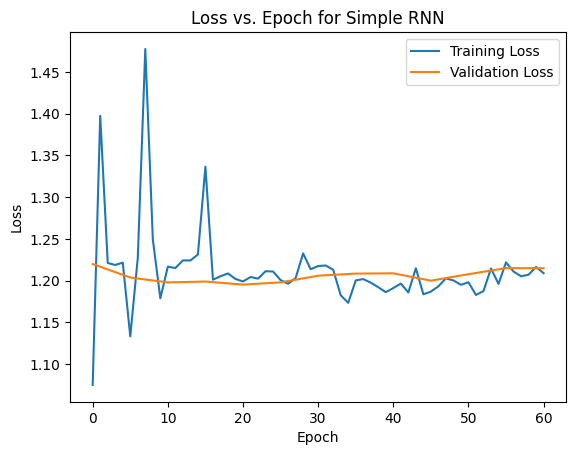

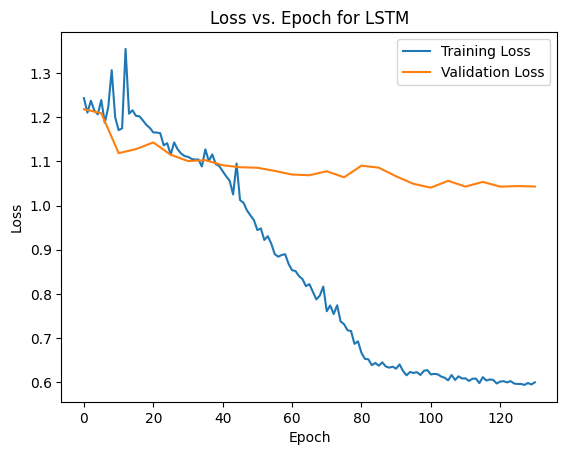

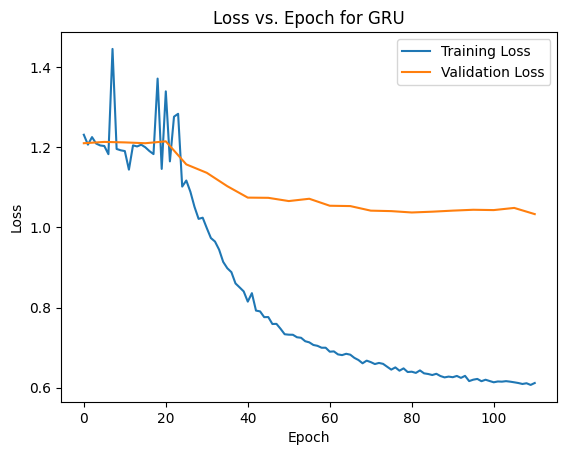

In [11]:
from math import e
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

comments = df['Cleaned_Text']
labels = np.array(df['Sentiment'])
labels[labels == 'positive'] = 2
labels[labels == 'neutral'] = 1
labels[labels == 'negative'] = 0
labels = np.array(labels, dtype=np.uint8)
comments = np.array(comments)

tokenized_comments = [comment.split() for comment in comments]
vocab = set([word for comment in tokenized_comments for word in comment])
vocab = {word: idx+1 for idx, word in enumerate(vocab)}
vocab['<PAD>'] = 0

# Padding
def pad_sequences(tokenized_comments, max_len=100):
    padded = []
    for comment in tokenized_comments:
        if len(comment) > max_len:
            padded.append(comment[:max_len])
        else:
            padded.append(comment + ['<PAD>'] * (max_len - len(comment)))
    return padded

padded_comments = pad_sequences(tokenized_comments)

# Encoding
encoded_comments = [[vocab[word] for word in comment] for comment in padded_comments]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(encoded_comments, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
X_train, y_train = load_dataset(np.array(X_train), y_train)
X_val, y_val = load_dataset(np.array(X_val), y_val)
X_test, y_test = load_dataset(np.array(X_test), y_test)
X_train = torch.tensor(X_train, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)


# Hyperparameters
epochs = 300
batch_size = 32
val_epoch = 5
learning_rate = 0.001
# SET TO FALSE IF TRAINING FROM SCRATCH
load_pretrained = False
train_l_rnn, val_l_rnn, test_pred_rnn, train_l_lstm, val_l_lstm, test_pred_lstm, train_l_gru, val_l_gru, test_pred_gru = None, None, None, None, None, None, None, None, None

if load_pretrained:
  model = myRNN(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/Simple_RNN.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_rnn, val_l_rnn = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_rnn = model(X_test)

  model = myLSTM(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/LSTM.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_lstm, val_l_lstm = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_lstm = model(X_test)

  model = myGRU(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/GRU.pt", weights_only = True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_gru, val_l_gru = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_gru = model(X_test)

else:
  model = myRNN(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_rnn, val_l_rnn, test_pred_rnn = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'Simple_RNN')
  print("-========= Done with simple RNN! ==========- \n")

  model = myLSTM(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_lstm, val_l_lstm, test_pred_lstm = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'LSTM')
  print("-========= Done with LSTM! ==========- \n")

  model = myGRU(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
  train_l_gru, val_l_gru, test_pred_gru = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'GRU')
  print("-========= Done with GRU! ==========- \n")





pred = np.argmax(test_pred_rnn, axis=1)
print("\nSimple RNN Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_lstm, axis=1)
print("\nLSTM Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_gru, axis=1)
print("\nGRU Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))


plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Training Loss")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for Simple RNN")
plt.show()

plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="Training Loss")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for LSTM")
plt.show()

plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="Training Loss")
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for GRU")
plt.show()

Below I have plotted these losses on the same axes for better comparison:

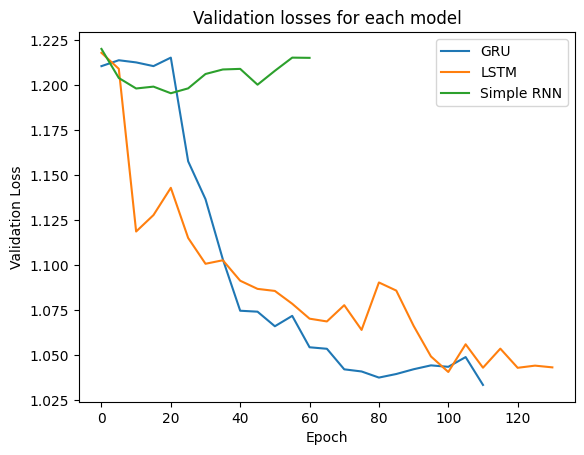

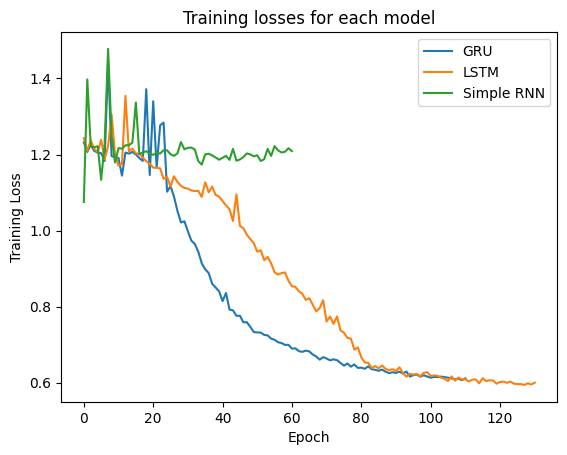

In [12]:
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation losses for each model")
plt.show()


plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training losses for each model")
plt.show()

Some things worth noticing: the simple RNN doesn't learn at all, and never gets past the "guessing" phase. It seems like the GRU losses are a lot more volatile than LSTM, which was apparent when training each model multiple times -- occasionally, GRU would never get past the guessing phase, similar to the simple RNN, and at other times, GRU would outperform LSTM. I think the disparity in performance from LSTM versus the basic RNN is mainly due to the forget gates implemented in the LSTM cell structure, as well as the issue with vanishing gradients. The ability for LSTMs to forget certain information means they get out of the "rut" of guessing very quickly, and the removal of vanishing gradients mean the weights get updated, while basic RNNs remain stagnant. I think the variability of GRUs compared to LSTMs is due to the removal of certain trainable parameters, which can make the loss more volatile. However, this also means that GRUs can converge more quickly than LSTMs in certain cases, which can be seen above.

Although I guess time-series data could technically be converted to the usual features in a feed-forward network (such as simply adding a feature for position of the word in a sentence), I don't think this would capture semantic context as well as RNNs. For example, the word "like" generally has a positive connotation, but when preluded by a qualifier like "not" or "didn't" this now implies a strongly negative connotation. Simple feed-forward networks would not be able to pick up on this interaction between words, while RNNs are able to since each word impacts the next one.

### Part 2: Word Embeddings

For word embeddings, I chose to use FastText. The reason for this is it allows for easy lookup of OOV word embeddings by using subword embeddings to approximate whole word embeddings. However, the natural trade-off is decreased semantic representation.

In [8]:
!git clone https://github.com/facebookresearch/fastText.git
!sudo pip install ./fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Counting objects: 100% (995/995), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 3998 (delta 886), reused 824 (delta 824), pack-reused 3003 (from 2)
Receiving objects: 100% (3998/3998), 8.30 MiB | 20.68 MiB/s, done.
Resolving deltas: 100% (2527/2527), done.
Processing ./fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp311-cp311-linux_x86_64.whl size=4313386 sha256=0d607b8bc1f1a6c1d5edd1ba6384b81b809f16979bdc48647aeb50690837f63c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fhmvhpc1/wheels/1e/bc/93/e4d717605b2816cf84bf6796e766c05fcc2fd4feb3f170fdf3
Successfully built fasttext


In [29]:
import fasttext
import fasttext.util
import numpy as np

ft = fasttext.load_model("/content/drive/MyDrive/Colab Notebooks/wiki.simple.bin")
fasttext.util.reduce_model(ft, 100) # Reduce model to 100 dimensions to reduce overhead -- my colab was occasionally running out of RAM without reducing dimensionality.


In [31]:
w1 = input("Input first word: ")
w2 = input("Input second word: ")

print(ft.get_word_vector(w1))
print(ft.get_word_vector(w2))

Input first word: cat
Input second word: dog
[ 0.23458758  0.3359176  -1.1792034   0.11905033  0.92409444  0.21441478
 -0.1436644   0.76755935  0.34944934 -0.17908329 -0.30552763  0.7788317
  0.4145707  -0.01853653  0.4402719  -0.41951588 -0.54648066  0.401248
 -0.1766725  -0.49539545  0.3135684   0.45503035  0.28758895  0.10372527
  0.38878134 -0.3718703  -0.10007501 -0.04760677  0.18724969 -0.33540905
 -0.3294418  -0.22748913 -0.44778624  0.19044898  0.2968199   0.542339
 -0.3920509  -0.613016   -0.45841172 -0.05204426  0.24037501  0.0716078
  0.3437278  -0.04447958 -0.17757179  0.34725845 -0.6002058  -0.06257948
 -0.20239507  0.172878    0.10016333  0.38468155  0.06434786 -0.1319954
  0.28960103  0.13897109 -0.04733545  0.3697808   0.02941013  0.24909395
  0.13931122 -0.12507334 -0.06251387  0.07041966 -0.09332858 -0.04684455
 -0.07353439  0.25386208  0.03998217  0.16980419 -0.5490905  -0.71570814
  0.43394566  0.2768747   0.08748184  0.04172411 -0.10783778 -0.3230693
  0.07127365 -

Cosine similarity is useful because it's a simple and easy way to compare word embeddings, and naturally falls within the range $[-1,1]$, making it easy to quickly determine how similar words are within the embedding space.

Input all words to be compared to each other, separated by a space: cat dog lion wolf jaguar tiger table truck boyfriend love wife husband mother hate detest time leave house museum closet
Cosine similarity between ['cat' 'cat'] : 1.0000
Cosine similarity between ['dog' 'cat'] : 0.7173
Cosine similarity between ['dog' 'dog'] : 1.0000
Cosine similarity between ['lion' 'cat'] : 0.5028
Cosine similarity between ['lion' 'dog'] : 0.4928
Cosine similarity between ['lion' 'lion'] : 1.0000
Cosine similarity between ['wolf' 'cat'] : 0.5360
Cosine similarity between ['wolf' 'dog'] : 0.5779
Cosine similarity between ['wolf' 'lion'] : 0.5330
Cosine similarity between ['wolf' 'wolf'] : 1.0000
Cosine similarity between ['jaguar' 'cat'] : 0.4496
Cosine similarity between ['jaguar' 'dog'] : 0.4612
Cosine similarity between ['jaguar' 'lion'] : 0.5804
Cosine similarity between ['jaguar' 'wolf'] : 0.3888
Cosine similarity between ['jaguar' 'jaguar'] : 1.0000
Cosine similarity between ['tiger' 'cat'] : 0.

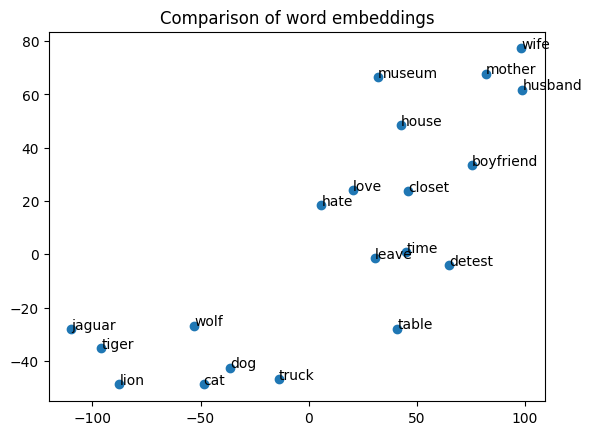

In [99]:
from sklearn.manifold import TSNE
from math import factorial

# Compute cosine similarity
def cosine_similarity(w1, w2):
  return np.sum((np.matmul(w1, w2.T)/(np.linalg.norm(w1, axis=1)*np.linalg.norm(w2, axis=1))*np.eye(np.shape(w1)[0])), axis=1)

i = input("Input all words to be compared to each other, separated by a space: ")
words = i.split(" ")
embeddings = [ft.get_word_vector(w) for w in words]
w1 = np.empty((sum(range(len(words)+1)),100))
w2 = np.empty((sum(range(len(words)+1)),100))
w3 = np.empty((sum(range(len(words)+1)),2), dtype = object)
for i in range(len(words)):
  for j in range(i+1):
    w1[sum(range(i+1))+j] = ft.get_word_vector(words[i])
    w2[sum(range(i+1))+j] = ft.get_word_vector(words[j])
    w3[sum(range(i+1))+j,0] = words[i]
    w3[sum(range(i+1))+j,1] = words[j]

cs = cosine_similarity(w1, w2)

for i in range(np.shape(w3)[0]):
  print("Cosine similarity between",w3[i,:],": {:.4f}".format(cs[i]))


x_embedded = TSNE(perplexity = 5).fit_transform(np.array(embeddings))

plt.scatter(x_embedded[:,0], x_embedded[:,1])
for i, txt in enumerate(words):
  plt.annotate(txt, (x_embedded[i,0],x_embedded[i,1]))
plt.title("Comparison of word embeddings")
# plt.ylim(0,100)
# plt.xlim(-100,100)
plt.show()

From the above scatter plot, we can see how similar words like ["dog","cat"], ["lion","tiger","jaguar"] and ["mother","husband","wife"] cluster very close together, while words that don't have a correlation with each other, like ["time","truck"] and ["wolf","table"] are relatively far apart. We can also see how these clusters all contain points with similar angles w.r.t. zero, indicating a high cosine similarity.

One possible option for dissimilarity is normalized euclidean distance, which would be implemented as: $$\frac{\|w_1-w_2\|}{\|w_1\|+\|w_2\|}$$ This captures slightly more than just cosine similarity, since it also factors in the magnitudes of each embedding, while cosine similarity only factors in the angle. IF two embeddings with similar angles have very large differences in magnitude, cosine embedding will be inaccurate when computing dissimilarity, while Euclidean distance captures the accurate difference. The normalization of Euclidean distance restricts the range to [0,1] so that the scale between vectors is the same for better comparison.

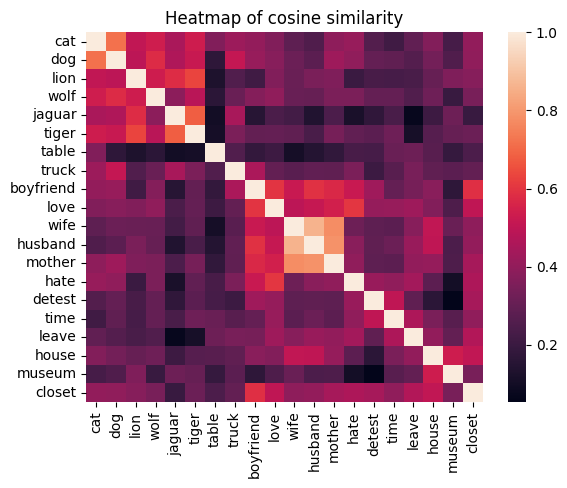

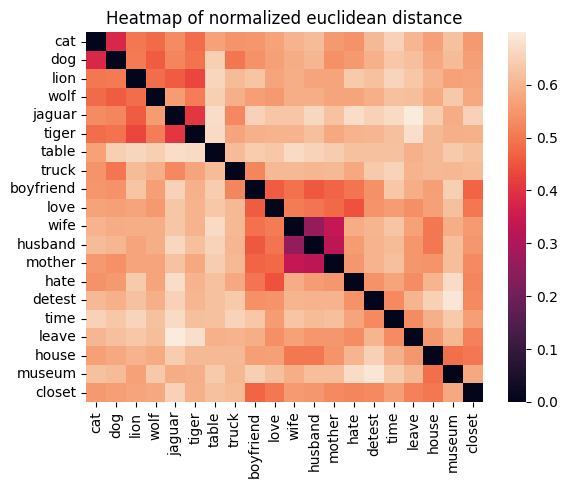

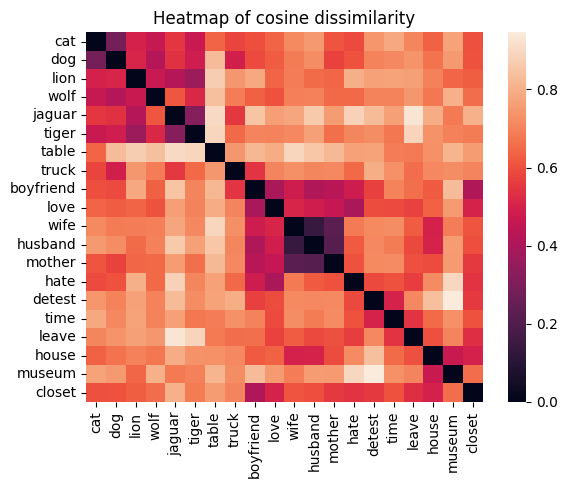

In [102]:
import seaborn as sns

def euclidean_dissimilarity(w1, w2):
  return (np.linalg.norm(w1-w2, axis=1))/(np.linalg.norm(w1, axis=1)+np.linalg.norm(w2, axis=1))
  # res = np.array(np.shape(w1)[0])
  # for i in range(np.shape(w1)[0])
  #   v1 = ft.get_word_vector(w1[i])
  #   v2 = ft.get_word_vector(w2[i])
  #   res[i] = np.linalg.norm(v1-v2)/(np.linalg.norm(v1)+np.linalg.norm(v2))
  # return res

def cosine_dissimilarity(w1, w2):
  return -1*cosine_similarity(w1, w2)+1


def word_compare(w1, w2, comparison):
  if comparison == "euc":
    return euclidean_dissimilarity(w1, w2)
  elif comparison == "cos":
    return cosine_similarity(w1, w2)
  elif comparison == "cos dis":
    return cosine_dissimilarity(w1, w2)
  else:
    print("Could not parse comparison method")

cs = word_compare(w1, w2, "cos")
ed = word_compare(w1, w2, "euc")
cd = word_compare(w1, w2, "cos dis")


df = pd.DataFrame(columns = words, index = words, dtype=float)

for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = cs[i]
  df.loc[w3[i,1],w3[i,0]] = cs[i]

sns.heatmap(df)
plt.title("Heatmap of cosine similarity")
plt.show()


for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = ed[i]
  df.loc[w3[i,1],w3[i,0]] = ed[i]

sns.heatmap(df)
plt.title("Heatmap of normalized euclidean distance")
plt.show()


for i in range(np.shape(w3)[0]):
  df.loc[w3[i,0],w3[i,1]] = cd[i]
  df.loc[w3[i,1],w3[i,0]] = cd[i]

sns.heatmap(df)
plt.title("Heatmap of cosine dissimilarity")
plt.show()

